# Object Detection using Histogram of Oriented Gradients (HOG) and Template Matching with Multi-scale Sliding Window

## Initializations

In [61]:
# Importing the required libraries
import cv2 as cv

# Visualization purposes
import matplotlib.pyplot as plt

# Only for arctan and degrees
import math

(578, 735, 3)


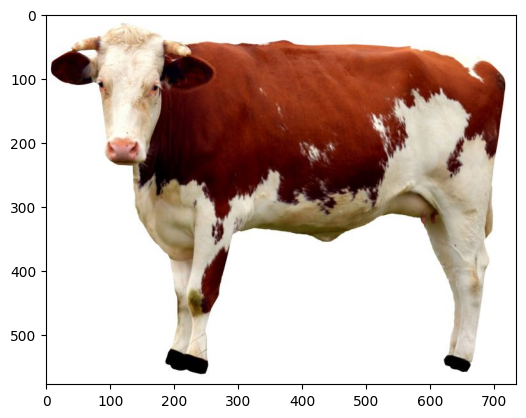

In [62]:
# Reading the image
img = cv.imread('./data/transparent.jpg')
print(img.shape)

plt.imshow(img[:,:,::-1])
plt.show()

In [63]:
# Converting the image to grayscale from scratch
def rgb2gray(img):
    return 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]

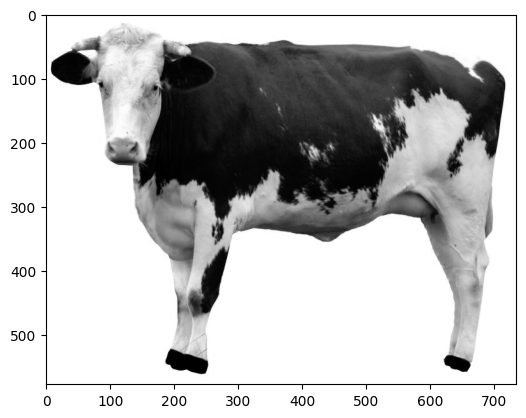

In [64]:
img = rgb2gray(img)

plt.imshow(img, cmap='gray')
plt.show()

In [65]:
PI = 3.14159265358979323846

def gaussian_blur(input_img, kernel_size, sigma):
    # Create kernel
    kernel = [[0 for i in range(kernel_size)] for j in range(kernel_size)]
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i][j] = 1/(2*PI*sigma**2)*math.exp(-((i-kernel_size//2)**2+(j-kernel_size//2)**2)/(2*sigma**2))

    output = input_img.copy()
    # # Padding the image with 0s according to kernel size
    padding = [[0 for i in range(input_img.shape[1]+kernel_size-1)] for j in range(input_img.shape[0]+kernel_size-1)]

    for i in range(len(input_img)):
        for j in range(len(input_img[i])):
            padding[i+1][j+1] = input_img[i][j]

    for i in range(len(input_img)):
        for j in range(len(input_img[i])):
            for k in range(len(kernel)):
                for l in range(len(kernel[k])):
                    output[i][j] = int(output[i][j] + kernel[k][l]*padding[i+k][j+l])

    return  output

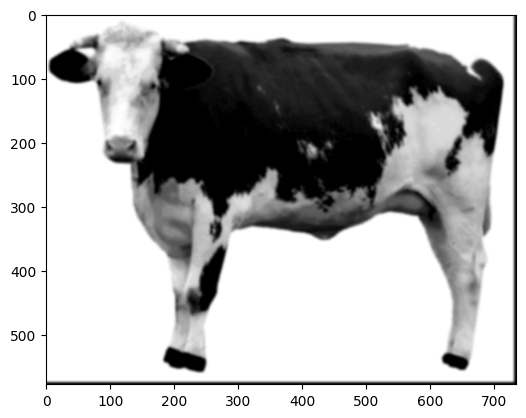

In [66]:
img = gaussian_blur(img, 9, 2)

plt.imshow(img, cmap='gray')
plt.show()

In [67]:
# Resizing the image
def resize(img, height, width):
    img2 = img.copy()[0:height,0:width,]

    mody = math.floor(img.shape[0] / height)
    modx = math.floor(img.shape[1] / width)

    # Mod
    y = 0
    x = 0

    for i in range(img.shape[0]):
        if (i % mody == 0):
            for j in range(img.shape[1]):
                if (j % modx == 0 and y<height and x<width):
                    img2[y][x] = img[i][j]
                    x += 1
            x = 0
            y += 1

    return img2

In [68]:
# Resizing the image
img = resize(img, 128, 64)

In [69]:
img.shape

(128, 64)

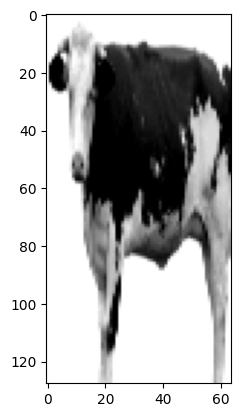

In [70]:
plt.imshow(img, cmap='gray')

## Histogram of Oriented Gradients (HOG)

### Gradient Calculation

In [71]:
# Square root function
def sqrt(x):
    return x**(1/2)

In [72]:
# Angle function
def angle(x, y):
    # Handling the case when x is 0
    if x == 0:
        return math.degrees(0.0)
    return math.degrees(abs(math.atan2(x, y)))

In [73]:
# Compute magnitude and orientation of gradients
def compute_gradient(img):
    magnitude = []
    orientation = []

    for i in range(1, len(img)-1):
        magnitude_row = []
        orientation_row = []
        for j in range(1, len(img[i])-1):
            # Gradient in x-direction
            gx = img[i+1][j] - img[i-1][j]
            # Gradient in y-direction
            gy = img[i][j+1] - img[i][j-1]
            magnitude_row.append(sqrt(gx**2 + gy**2))
            orientation_row.append(angle(gx, gy))
        magnitude.append(magnitude_row)
        orientation.append(orientation_row)

    return magnitude, orientation

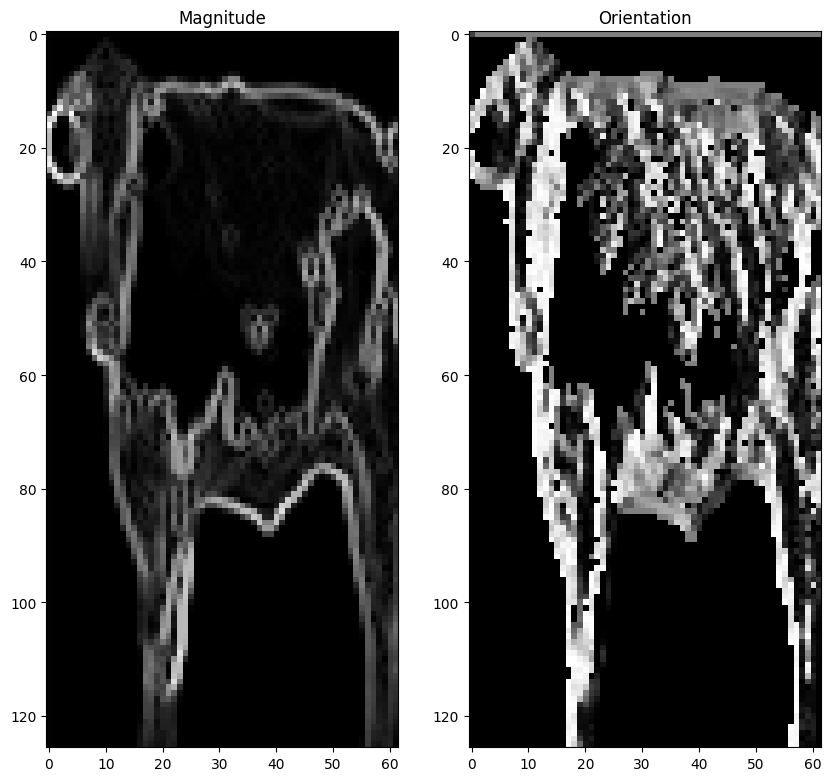

In [74]:
# Computing the gradient
magnitude, orientation = compute_gradient(img)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(magnitude, cmap='gray')
plt.title('Magnitude')
plt.subplot(1, 2, 2)
plt.imshow(orientation, cmap='gray')
plt.title('Orientation')
plt.show()

### Orientation Binning

In [75]:
# Computing the histogram
def compute_histogram(orientation, magnitude, cell_size):
    histogram = []
    for i in range(0, len(orientation), cell_size):
        histogram_row = []
        for j in range(0, len(orientation[i]), cell_size):
            histogram_cell = [0]*9
            for k in range(i, i+cell_size):
                if k >= len(orientation):
                    continue
                for l in range(j, j+cell_size):
                    if l >= len(orientation[k]):
                        continue 
                    # print(k, l)
                    if orientation[k][l] >= 0 and orientation[k][l] < 20:
                        histogram_cell[0] += magnitude[k][l]
                    elif orientation[k][l] >= 20 and orientation[k][l] < 40:
                        histogram_cell[1] += magnitude[k][l]
                    elif orientation[k][l] >= 40 and orientation[k][l] < 60:
                        histogram_cell[2] += magnitude[k][l]
                    elif orientation[k][l] >= 60 and orientation[k][l] < 80:
                        histogram_cell[3] += magnitude[k][l]
                    elif orientation[k][l] >= 80 and orientation[k][l] < 100:
                        histogram_cell[4] += magnitude[k][l]
                    elif orientation[k][l] >= 100 and orientation[k][l] < 120:
                        histogram_cell[5] += magnitude[k][l]
                    elif orientation[k][l] >= 120 and orientation[k][l] < 140:
                        histogram_cell[6] += magnitude[k][l]
                    elif orientation[k][l] >= 140 and orientation[k][l] < 160:
                        histogram_cell[7] += magnitude[k][l]
                    elif orientation[k][l] >= 160 and orientation[k][l] < 180:
                        histogram_cell[8] += magnitude[k][l]
            histogram_row.append(histogram_cell)
        histogram.append(histogram_row)
    return histogram

In [76]:
# Computing the histogram
histogram = compute_histogram(orientation, magnitude, 8)

In [77]:
len(histogram), len(histogram[0]), len(histogram[0][0])

(16, 8, 9)

### HOG Feature Vector

In [78]:
epsilon = 1e-05

def hog_feature_vector(histogram):
    feature_vectors = []
    for i in range(0, len(histogram) - 1, 1):
        temp = []
        for j in range(0, len(histogram[0]) - 1, 1):
            values = [[histogram[i][x] for x in range(j, j+2)] for i in range(i, i+2)]
            final_vector = []
            for k in values:
                for l in k:
                    for m in l:
                        final_vector.append(m)
            k = round(sqrt(sum([pow(x, 2) for x in final_vector])), 9)
            final_vector = [round(x/(k + epsilon), 9) for x in final_vector]
            temp.append(final_vector)
        feature_vectors.append(temp)
    return feature_vectors

In [79]:
feature_vectors = hog_feature_vector(histogram)

In [80]:
print(feature_vectors)
print(len(feature_vectors), len(feature_vectors[0]), len(feature_vectors[0][0]))

[[[0.007572037, 0.0, 0.001460247, 0.0, 0.045351515, 0.019735632, 0.039375525, 0.016624454, 0.017539493, 0.030541053, 0.043076041, 0.055412889, 0.08094229, 0.053896631, 0.027978525, 0.034766777, 0.04462051, 0.0, 0.393677661, 0.267182204, 0.090666056, 0.099566634, 0.000344183, 0.05543064, 0.52004259, 0.491508491, 0.104486972, 0.169449718, 0.065848412, 0.052085124, 0.049028482, 0.007925773, 0.05945046, 0.059882385, 0.06375467, 0.395134086], [0.039750272, 0.056065008, 0.072121856, 0.105349285, 0.070148392, 0.03641505, 0.045250203, 0.058075189, 0.0, 0.008354188, 0.0, 0.0, 0.0, 0.014334947, 0.0, 0.0, 0.0, 0.0, 0.220544866, 0.085704062, 0.067790651, 0.063812322, 0.010315677, 0.077376899, 0.077939065, 0.082978983, 0.514281139, 0.0, 0.191423663, 0.135969902, 0.419652272, 0.301778256, 0.429299247, 0.026675679, 0.227108381, 0.244838738], [0.008032314, 0.0, 0.0, 0.0, 0.013782644, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012490521, 0.0, 0.0, 0.0, 0.0, 0.0, 0.184048406, 0.130731193, 0.403483721, 0.

## Extracting HOG Features from Images

In [81]:
# Simplified HOG feature extraction
def hog_feature_extraction(img):
    img = rgb2gray(img)
    img = gaussian_blur(img, 9, 2)
    img = resize(img, 128, 64)
    magnitude, orientation = compute_gradient(img)
    histogram = compute_histogram(orientation, magnitude, 8)
    feature_vectors = hog_feature_vector(histogram)
    return feature_vectors

## Testing the HOG Feature Vector on a Sample Image

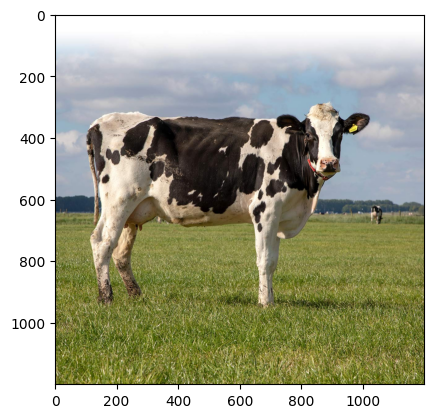

In [82]:
original_input = cv.imread('./data/bg.jpg')

plt.imshow(original_input[:,:,::-1])
plt.show()

In [83]:
# Rotate the image 180 degrees (only for this testing purpose)
def rotate180(img):
    img2 = img.copy()

    # Rotating the image on vertical axis
    for i in range(len(img)):
        for j in range(len(img[i])):
            img2[i][len(img[i])-j-1] = img[i][j]

    return img2

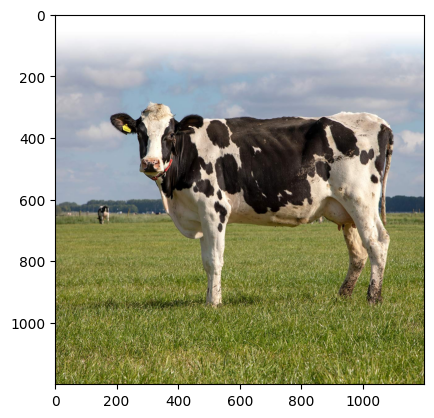

In [84]:
# In order to match the feature vector
original_input = rotate180(original_input)
img_input = original_input.copy()

plt.imshow(img_input[:,:,::-1])
plt.show()

### Multi-Scale Detection

In [85]:
import imutils

# Defining the pyramid
def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image

    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)

        if len(image) < minSize[1] or len(image[0]) < minSize[0]:
            break

        yield image

In [86]:
# Defining the sliding window
def sliding_window(image, stepSize, windowSize):
    for y in range(0, len(image), stepSize):
        for x in range(0, len(image[y]), stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [87]:
# Defining logical AND operation
def logical_and(a, b):
    for i in range(len(a)):
        for j in range(len(a[i])):
            a[i][j] = a[i][j] & b[i][j]
    return a

# Defining logical OR operation
def logical_or(a, b):
    for i in range(len(a)):
        for j in range(len(a[i])):
            a[i][j] = a[i][j] | b[i][j]
    return a

In [88]:
# Defining IOU function
def get_iou(a, b):
    intersection = logical_and(a, b)
    union = logical_or(a, b)

    sum_intersection = 0
    for i in range(len(intersection)):
        for j in range(len(intersection[i])):
            if intersection[i][j][0] == 255 and intersection[i][j][1] == 255 and intersection[i][j][2] == 255:
                sum_intersection += 1

    sum_union = 0
    for i in range(len(union)):
        for j in range(len(union[i])):
            if union[i][j][0] == 255 and union[i][j][1] == 255 and union[i][j][2] == 255:
                sum_union += 1

    if sum_union == 0 or sum_intersection == 0:
        return 0

    iou = sum_intersection / sum_union

    return iou

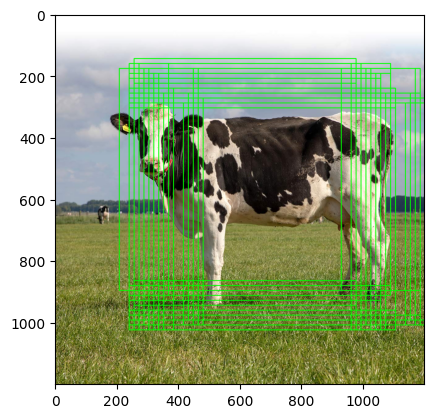

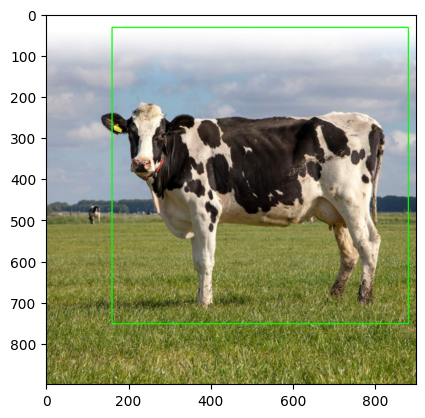

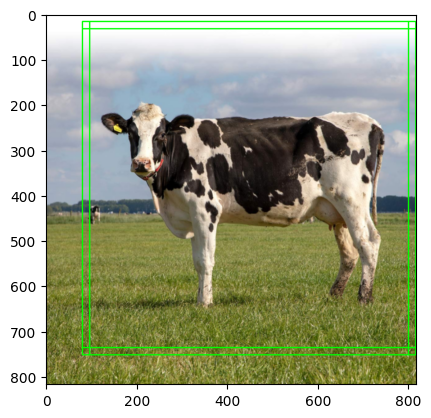

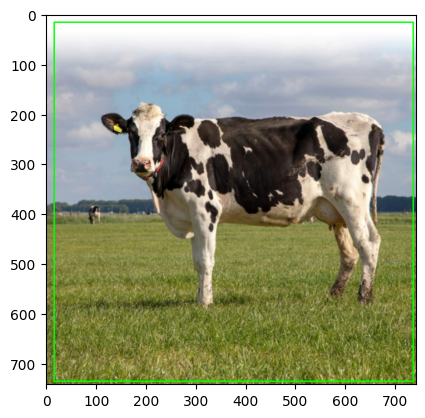

In [89]:
# Defining the sliding window size and step size
windowSize = (720, 720)
stepSize = 16
window_matches = []
last_window = None
ratios = []

# Looping over the sliding window for each layer of the pyramid
for resized in pyramid(img_input, scale=1.1):
    ratio = img_input.shape[1] / float(resized.shape[1])
    ratios.append(ratio)

    # Looping over the sliding window for each layer of the pyramid
    clone = resized.copy()
    is_drawed = False

    for (x, y, window) in sliding_window(resized, stepSize=stepSize, windowSize=windowSize):
        # If the window does not meet our desired window size, ignore it!
        if window.shape[0] != windowSize[1] or window.shape[1] != windowSize[0]:
            continue

        # Computing the HOG features for the window
        input_vectors = hog_feature_extraction(window)

        # Compare the HOG features for the window with the HOG features for the image
        # If the window is a match, record it
        # Otherwise, continue searching
        is_detected = True
        current_window = resized[y:y + windowSize[1], x:x + windowSize[0]]

        # Thresholding the HOG features
        for i in range(len(input_vectors)):
            row_sum = 0
            for j in range(len(input_vectors[i])):
                cumulative_sum = 0
                for k in range(len(input_vectors[i][j])):
                    # Squared difference between the input vector and the feature vector
                    cumulative_sum += pow(input_vectors[i][j][k] - feature_vectors[i][j][k], 2)
                # Summing the minimum distances
                row_sum += sqrt(cumulative_sum)
            # If the sum is greater than 8, then the window is not a match
            if row_sum > 8:
                is_detected = False
                break

        if is_detected:
            if last_window is not None:
                # Compute the intersection over union
                iou = get_iou(last_window, current_window)

                # If the intersection over union is greater than 0.5, then we have a match
                if iou > 0.5:
                    # Get the coordinates from the center of the window
                    x1, y1, x2, y2 = x, y, x + windowSize[1], y + windowSize[0]

                    # Append the coordinates to the window_matches list
                    window_matches.append(((x1, y1, x2, y2), ratio))

                    # Draw the rectangle on the image
                    cv.rectangle(clone, (x, y), (x + windowSize[0], y + windowSize[1]), (0, 255, 0), 2)
                    is_drawed = True
                    
            last_window = current_window.copy()
    if is_drawed:
        plt.imshow(clone[:,:,::-1])
        plt.show()

## Analyze the matched windows

In [90]:
window_matches

[((256, 144, 976, 864), 1.0),
 ((240, 160, 960, 880), 1.0),
 ((256, 160, 976, 880), 1.0),
 ((272, 160, 992, 880), 1.0),
 ((368, 160, 1088, 880), 1.0),
 ((208, 176, 928, 896), 1.0),
 ((240, 176, 960, 896), 1.0),
 ((256, 176, 976, 896), 1.0),
 ((272, 176, 992, 896), 1.0),
 ((288, 176, 1008, 896), 1.0),
 ((304, 176, 1024, 896), 1.0),
 ((368, 176, 1088, 896), 1.0),
 ((448, 176, 1168, 896), 1.0),
 ((464, 176, 1184, 896), 1.0),
 ((240, 192, 960, 912), 1.0),
 ((256, 192, 976, 912), 1.0),
 ((272, 192, 992, 912), 1.0),
 ((288, 192, 1008, 912), 1.0),
 ((304, 192, 1024, 912), 1.0),
 ((320, 192, 1040, 912), 1.0),
 ((336, 192, 1056, 912), 1.0),
 ((368, 192, 1088, 912), 1.0),
 ((240, 208, 960, 928), 1.0),
 ((256, 208, 976, 928), 1.0),
 ((272, 208, 992, 928), 1.0),
 ((288, 208, 1008, 928), 1.0),
 ((336, 208, 1056, 928), 1.0),
 ((256, 224, 976, 944), 1.0),
 ((240, 240, 960, 960), 1.0),
 ((256, 240, 976, 960), 1.0),
 ((272, 240, 992, 960), 1.0),
 ((384, 240, 1104, 960), 1.0),
 ((240, 256, 960, 976), 1.

In [91]:
ratios

[1.0,
 1.1009174311926606,
 1.2121212121212122,
 1.3348164627363737,
 1.4687882496940023,
 1.6172506738544474,
 1.7804154302670623,
 1.9607843137254901,
 2.158273381294964,
 2.376237623762376,
 2.6143790849673203,
 2.8776978417266186,
 3.1662269129287597,
 3.488372093023256,
 3.8461538461538463,
 4.240282685512367,
 4.669260700389105,
 5.150214592274678,
 5.687203791469194,
 6.282722513089006,
 6.936416184971098,
 7.643312101910828,
 8.450704225352112,
 9.30232558139535,
 10.256410256410257,
 11.320754716981131,
 12.5,
 13.793103448275861,
 15.189873417721518,
 16.901408450704224,
 18.75,
 20.689655172413794,
 23.076923076923077,
 25.53191489361702,
 28.571428571428573,
 31.57894736842105,
 35.294117647058826,
 40.0]

In [92]:
# Get max ratio from coordinates
max_ratio = max(window_matches, key=lambda x: x[1])[1]

# Limit the ratios to the max ratio
ratios = [x for x in ratios if x <= max_ratio]

In [93]:
# Get top-left, top-right, bottom-left, and bottom-right coordinates of the window matches for each layer of the pyramid
def get_coordinates(window_matches, ratio):
    coordinates = []
    for window_match in window_matches:
        if window_match[1] == ratio:
            x1, y1, x2, y2 = window_match[0]
            coordinates.append((x1, y1))
            coordinates.append((x2, y1))
            coordinates.append((x1, y2))
            coordinates.append((x2, y2))
    return coordinates

In [94]:
# Get the minimum and maximum x and y coordinates
def get_min_max_coordinates(coordinates):
    min_x_coor = min(coordinates, key=lambda x: x[0])[0]
    min_y_coor = min(coordinates, key=lambda x: x[1])[1]
    max_x_coor = max(coordinates, key=lambda x: x[0])[0]
    max_y_coor = max(coordinates, key=lambda x: x[1])[1]

    return min_x_coor, min_y_coor, max_x_coor, max_y_coor

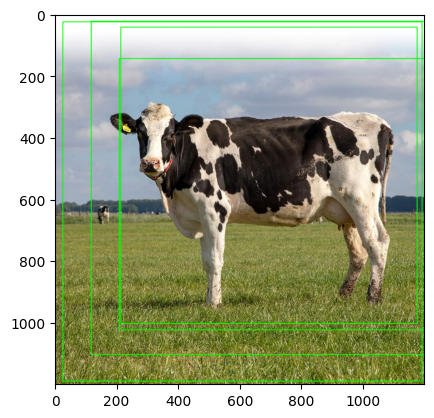

In [95]:
min_x, min_y, max_x, max_y = 0, 0, 0, 0

clone = original_input.copy()
for ratio in ratios:
    coordinates = get_coordinates(window_matches, ratio)
    if len(coordinates) == 0:
        continue
    min_x_coor, min_y_coor, max_x_coor, max_y_coor = get_min_max_coordinates(coordinates)

    # Multiply the coordinates by the ratio
    min_x_coor = int(min_x_coor * ratio)
    min_y_coor = int(min_y_coor * ratio)
    max_x_coor = int(max_x_coor * ratio)
    max_y_coor = int(max_y_coor * ratio)

    # Draw the bounding box for the coordinates
    cv.rectangle(clone, (min_x_coor, min_y_coor), (max_x_coor, max_y_coor), (0, 255, 0), 2)

    # Get the intersection of the bounding boxes
    if min_x == 0 and min_y == 0 and max_x == 0 and max_y == 0:
        min_x, min_y, max_x, max_y = min_x_coor, min_y_coor, max_x_coor, max_y_coor
    else:
        min_x = max(min_x, min_x_coor)
        min_y = max(min_y, min_y_coor)
        max_x = min(max_x, max_x_coor)
        max_y = min(max_y, max_y_coor)
plt.imshow(clone[:,:,::-1])
plt.show()

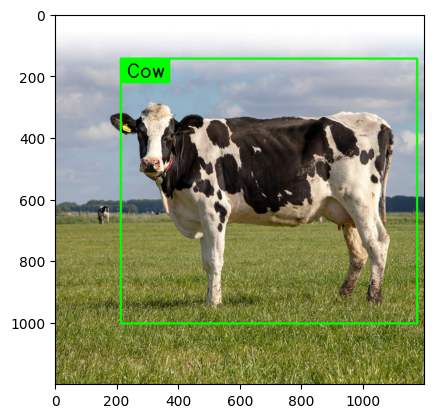

In [96]:
clone = original_input.copy()
# Draw the bounding box for the coordinates
cv.rectangle(clone, (min_x, min_y), (max_x, max_y), (0, 255, 0), 6)
# Create rectangle for the label
cv.rectangle(clone, (min_x, min_y), (min_x + 160, min_y + 80), (0, 255, 0), -1)
# Draw the label for the bounding box
cv.putText(clone, "Cow", (min_x+ 20, min_y + 60), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3)

plt.imshow(clone[:,:,::-1])
plt.show()

## Simplify the detect function

In [97]:
def detect(img, windowSize, rotate=False):
    input = img.copy()

    # Rotate the image 180 degrees if rotate180 is True
    if rotate:
        input = rotate180(input)

    # Defining the sliding window size and step size
    windowSize = (windowSize, windowSize)
    stepSize = 16
    window_matches = []
    last_window = None
    ratios = []

    # Looping over the sliding window for each layer of the pyramid
    for resized in pyramid(input, scale=1.1):
        ratio = input.shape[1] / float(resized.shape[1])
        ratios.append(ratio)
        # Looping over the sliding window for each layer of the pyramid
        for (x, y, window) in sliding_window(resized, stepSize=stepSize, windowSize=windowSize):
            # If the window does not meet our desired window size, ignore it!
            if window.shape[0] != windowSize[1] or window.shape[1] != windowSize[0]:
                continue

            # Computing the HOG features for the window
            input_vectors = hog_feature_extraction(window)

            # Compare the HOG features for the window with the HOG features for the image
            # If the window is a match, record it
            # Otherwise, continue searching
            is_detected = True
            current_window = resized[y:y + windowSize[1], x:x + windowSize[0]]

            # Thresholding the HOG features
            for i in range(len(input_vectors)):
                row_sum = 0
                for j in range(len(input_vectors[i])):
                    cumulative_sum = 0
                    for k in range(len(input_vectors[i][j])):
                        # Squared difference between the input vector and the feature vector
                        cumulative_sum += pow(input_vectors[i][j][k] - feature_vectors[i][j][k], 2)
                    # Summing the minimum distances
                    row_sum += sqrt(cumulative_sum)
                # If the sum is greater than 8, then the window is not a match
                if row_sum > 8:
                    is_detected = False
                    break

            if is_detected:
                if last_window is not None:
                    # Compute the intersection over union
                    iou = get_iou(last_window, current_window)

                    # If the intersection over union is greater than 0.5, then we have a match
                    if iou > 0.5:
                        # Get the coordinates from the center of the window
                        x1, y1, x2, y2 = x, y, x + windowSize[1], y + windowSize[0]

                        # Append the coordinates to the window_matches list
                        window_matches.append(((x1, y1, x2, y2), ratio))
                        
                last_window = current_window.copy()

    # Get max ratio from coordinates
    max_ratio = max(window_matches, key=lambda x: x[1])[1]

    # Limit the ratios to the max ratio
    ratios = [x for x in ratios if x <= max_ratio]

    min_x, min_y, max_x, max_y = 0, 0, 0, 0

    clone = img.copy()
    for ratio in ratios:
        coordinates = get_coordinates(window_matches, ratio)
        if len(coordinates) == 0:
            continue
        min_x_coor, min_y_coor, max_x_coor, max_y_coor = get_min_max_coordinates(coordinates)

        # Multiply the coordinates by the ratio
        min_x_coor = int(min_x_coor * ratio)
        min_y_coor = int(min_y_coor * ratio)
        max_x_coor = int(max_x_coor * ratio)
        max_y_coor = int(max_y_coor * ratio)

        # Draw the bounding box for the coordinates
        cv.rectangle(clone, (min_x_coor, min_y_coor), (max_x_coor, max_y_coor), (0, 255, 0), 2)

        # Get the intersection of the bounding boxes
        if min_x == 0 and min_y == 0 and max_x == 0 and max_y == 0:
            min_x, min_y, max_x, max_y = min_x_coor, min_y_coor, max_x_coor, max_y_coor
        else:
            min_x = max(min_x, min_x_coor)
            min_y = max(min_y, min_y_coor)
            max_x = min(max_x, max_x_coor)
            max_y = min(max_y, max_y_coor)

    # Draw the bounding box
    clone = img.copy()
    cv.rectangle(clone, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)
    cv.rectangle(clone, (min_x, min_y), (min_x + 160, min_y + 80), (0, 255, 0), -1)
    cv.putText(clone, "Cow", (min_x+ 20, min_y + 60), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3)
    plt.imshow(clone[:,:,::-1])
    plt.show()

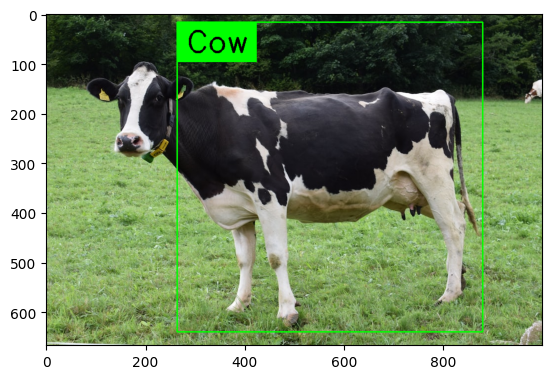

In [98]:
img = cv.imread('./data/test.jpeg')
detect(img, windowSize=512)